In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc

import matplotlib as mpl
label_size= 24
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_statespace")

print(dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_statespace


In [59]:
p_names = ["D-exp", "D-osc", "U-exp", "U-osc", "Bi-exp", "Bi-osc", "Osc", "Bi-phase-osc", "Beat", "Bi-period-osc", "Bi-stat-osc"]
coords = [[1., 1.5], [1.5, 1.], [3., 1.], [2.3, 0.5], [2.2, 2.1], [2.5, 1.8], [1.0, 0.3], [1.7, 0.8], [1.3, 0.6], [1.1, 0.5], [2.1, 0.8]]

coords_names = coords.copy()
for ci, c in enumerate(coords_names):
    c.append(p_names[ci])

print(coords_names)

delay_array = [0., 4.75, 9.5, 14.25, 19.]
coupling_array = [0.0, 0.2, 0.6, 1.0, 1.4, 1.8, 2.2]

cmats = []
cmats.append(np.array( [[0., 0.], [1., 0.]] ))
cmats.append(np.array( [[0., 1.], [1., 0.]] ))

N = 2

[[1.0, 1.5, 'D-exp'], [1.5, 1.0, 'D-osc'], [3.0, 1.0, 'U-exp'], [2.3, 0.5, 'U-osc'], [2.2, 2.1, 'Bi-exp'], [2.5, 1.8, 'Bi-osc'], [1.0, 0.3, 'Osc'], [1.7, 0.8, 'Bi-phase-osc'], [1.3, 0.6, 'Beat'], [1.1, 0.5, 'Bi-period-osc'], [2.1, 0.8, 'Bi-stat-osc']]


In [60]:
statespace = [ [ [dict() for x0 in range(len(delay_array))] for x1 in range(len(coupling_array)) ] for x2 in range(len(cmats)) ]

dx = 0.1
emin, emax, imin, imax = 0.5, 3.1, 0., 2.1
eext = np.arange(emin, emax + dx, dx)
iext = np.arange(imin, imax + dx, dx)

LIMOSCBI = 2.
LIMOSCPHASE = 2.0
LIMOSCBEAT = 1e-2

In [81]:
roundint = 3

def getstate(exc0, exc1):
    ### possible outcomes:
    # ["static", [mean0, mean1]]
    # ["osc", [period, phase]]
    # ["beating", [period0, period1]]
    # ["osc/ static", [mean0, period1]]
    # ["static/ osc", [period0, mean1]]
    PROM = 0.02
    state = [None, None]

    peaks0 = scipy.signal.find_peaks(exc0, prominence=PROM)[0]
    peaks1= scipy.signal.find_peaks(exc1, prominence=PROM)[0]

    if False and len(peaks0) > 4:
        fig, ax = plt.subplots(2,1, figsize=(15,10))
        ax[0].plot(exc0[:2000])
        ax[0].vlines(peaks0, 0, 0.5, color="grey")
        ax[1].plot(exc1[:2000])
        ax[1].vlines(peaks1, 0, 0.5, color="grey")
        ax[0].set_xlim(0, 2000)
        ax[1].set_xlim(0, 2000)
        plt.show()

    if len(peaks0) == 0 and len(peaks1) == 0:
        state[0] = "static"
        state[1] = [np.around(np.mean(exc0),roundint), np.around(np.mean(exc1),roundint) ]
    elif len(peaks0) > 3 and len(peaks1) > 3:
        period0 = getperiods(peaks0)
        period1 = getperiods(peaks1)
        amps0 = exc0[peaks0]
        amps1 = exc1[peaks0]
        varamps = np.var(amps0) + np.var(amps1)
        phase = getphase(peaks0, peaks1, period0, period1)

        #print(period0, period1)
        #print(phase)
        #print(varamps)

        if phase[1] > phase[0]:
            state[0] = "beating"
            state[1] = [period0, period1]
        elif varamps > 1e-3 * max( np.amax(amps0), np.amax(amps1) ) and phase[1] > LIMOSCPHASE:
            print("beating because of amplitude differences ")
            state[0] = "beating"
            state[1] = [period0, period1]
        elif np.abs(period0 - period1) <= LIMOSCBEAT:
            state[0] = "osc"
            state[1] = [period0, phase]
        elif np.abs(period0 - period1) > LIMOSCBEAT and phase[1] > 0.2*phase[0]:
                state[0] = "beating"
                state[1] = [period0, period1]
        elif phase[1] > 0.5 * phase[0]:
            state[0] = "beating"
            state[1] = [period0, period1]
        else:
            print("osc state unclear ", period0, period1, phase)
            #print("osc at different freq ", state[1])
    elif len(peaks0) > 3:
        state[0] = "osc/ static"
        period0 = getperiods(peaks0)
        state[1] = [period0, np.around(np.mean(exc1),roundint)]
    elif len(peaks1) > 3:
        state[0] = "static/ osc"
        period1 = getperiods(peaks1)
        state[1] = [np.around(np.mean(exc0),roundint), period1]
    else:
        print("WARNING ", peaks0, peaks1)

    return state 

def getperiods(peaks):
    pl = []
    for p in range(4, len(peaks)-4):
        pl.append( (peaks[p] - peaks[p-1]) * model.params.dt )
    return np.around(np.mean(pl),roundint)

def getphase(p0, p1, period0, period1):
    phdiff = []
    #print(p0[:12])
    #print(p1[:12])
    for refpeak in p0[2:-2]:
        for i in range(len(p1)):
            if p1[i] > refpeak:
                indit = i-1
                break
        
        phdiff.append( (refpeak - p1[indit]) * model.params.dt)

    for ip in np.arange(len(phdiff)-1, -1, -1):
        if np.abs(period0 - phdiff[ip]) < LIMOSCBEAT:
            phdiff[ip] = 0.
            
    mean = np.mean(phdiff)
    var = np.var(phdiff)
    return np.around(mean,roundint), np.around(var, roundint)

1 0 0
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 6 0
1 6 1
1 6 2


beating because of amplitude differences 
beating because of amplitude differences 
beating because of amplitude differences 
beating because of amplitude differences 
beating because of amplitude differences 
beating because of amplitude differences 
beating because of amplitude differences 
beating because of amplitude differences 


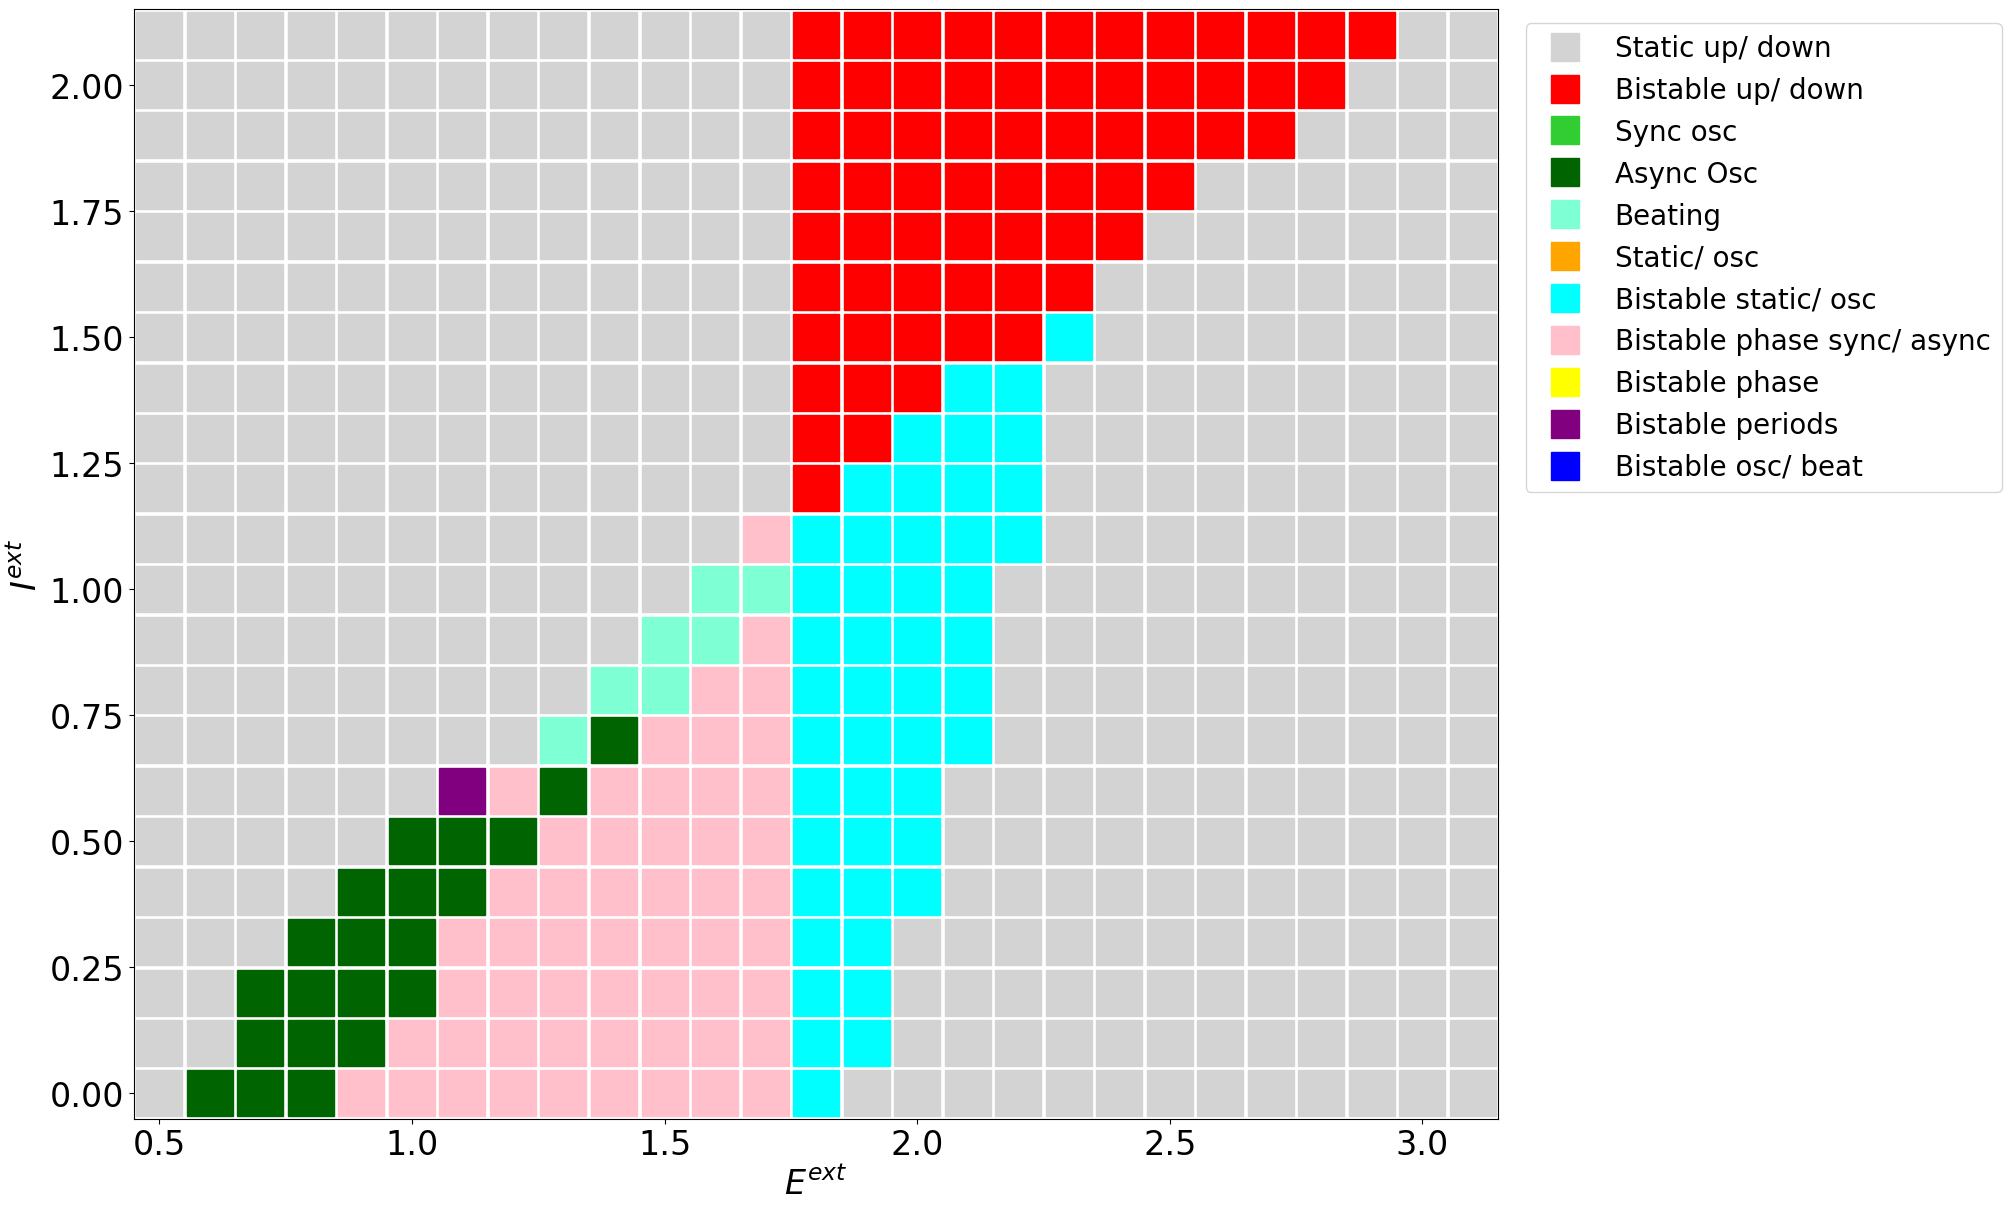

1 6 3
1 6 4


In [130]:
for i in range(len(cmats)):

    if i != 1: continue

    for ci in range(len(coupling_array)):

        for di in range(len(delay_array)):

            if ci in [0] and di not in [0]:
                continue

            print(i, ci, di)

            if ci not in [6]: continue
            if di not in [2]: continue  #4

            statespace[i][ci][di]["coords"] = []
            statespace[i][ci][di]["state"] = []

            for e_ in eext:
                
                for i_ in iext:

                    #if np.abs(e_ - 1.1) > 1e-2 or np.abs(i_ - 0.2) > 1e-2: continue
                    #if np.abs(e_ - 2.5) > 1e-2 and np.abs(e_ - 2.4) > 1e-2 and np.abs(e_ - 2.6) > 1e-2: continue
                    #if np.abs(i_ - 1.3) > 1e-2 and np.abs(i_ - 1.2) > 1e-2 and np.abs(i_ - 1.4) > 1e-2: continue

                    dmat = delay_array[di] * cmats[i] * 20.
                
                    model = WCModel(Cmat=cmats[i], Dmat=dmat)
                    model.params.K_gl = coupling_array[ci]
                    dt = 0.1
                    model.params.dt = dt

                    dur = 100.
                    measure_dur = 30.
                    i00, i01 = int( (0.5 * dur - measure_dur) * 1000. / dt), int(0.5 * dur * 1000./dt) - 1
                    i10, i11 = int(-measure_dur * 1000. / dt), -1

                    model.params['duration'] = dur * 1000 # Simulation time, ms
                    test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
                    test_input[:,:int(50/dt)] = 6.
                    test_input[:,i01+1:i01+1+int(50/dt)] = -6.
                    model.params.exc_ext_baseline = e_
                    model.params.inh_ext_baseline = i_
                    model.params.exc_ext = test_input

                    model.run()

                    state0 = getstate(model.exc[0,i00:i01], (model.exc[1,i00:i01]))
                    state1 = getstate(model.exc[0,i10:i11], (model.exc[1,i10:i11]))

                    state = None

                    if state0[0] == "static" and state1[0] == "static":
                        if np.abs(state0[1][0] - state1[1][0]) < 1e-1 and np.abs(state0[1][1] - state1[1][1]) < 1e-1:
                            state = state0.copy()
                        else:
                            state = ["bistable", [state0[1], state1[1]] ]

                    elif state0[0] == "beating" and state1[0] == "beating":
                        if np.abs(state0[1][0] - state1[1][0]) <= LIMOSCBI and np.abs(state0[1][1] - state1[1][1]) <= LIMOSCBI:
                            state = state0.copy()
                        elif np.abs(state0[1][0] - state1[1][1]) <= LIMOSCBI and np.abs(state0[1][1] - state1[1][0]) <= LIMOSCBI:
                            state = state0.copy()
                        else:
                            print("beating at different freqs?")
                            print(state0, state1)                        

                    elif state0[0] == "osc/ static" and state1[0] == "osc/ static":
                        if np.abs(state0[1][0] - state1[1][0]) <= 1e-1 and np.abs(state0[1][1] - state1[1][1]) <= 1e-1:
                            state = state0.copy()
                        else:
                            print("osc/ static with different values")
                            print(state0)
                            print(state1)
                        
                    elif state0[0] == "static/ osc" and state1[0] == "static/ osc":
                        if np.abs(state0[1][0] - state1[1][0]) <= 1e-1 and np.abs(state0[1][1] - state1[1][1]) <= 1e-1:
                            state = state0.copy()
                        else:
                            print("static/ osc with different values")
                            print(state0)
                            print(state1)

                    elif state0[0] == "osc" and state1[0] == "beating":
                        print("osc and beating bistability")
                        state = ["bi osc/ beating", [state0[1][0], state1[1]]]
                        #state = state1.copy()
                    elif state0[0] == "beating" and state1[0] == "osc":
                        print("beating and osc bistability")
                        state = ["bi osc/ beating", [state1[1][0], state0[1]]]
                        #state = state0.copy()   
                    
                    elif state0[0] == "static" and state1[0] == "osc":
                        state = ["bi static/ osc", [state0[1], state1[1]]]
                    elif state0[0] == "osc" and state1[0] == "static":
                        state = ["bi static/ osc", [state1[1], state0[1]]]

                    elif state0[0] == "osc" and state is None:

                        test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
                        test_input = np.vstack( ([test_input]*N))
                        stim_period = int(state0[1][0])

                        for amp in np.arange(0.5, 5.1, 0.5):
                            test_input[0,:2*int(stim_period/dt)] = amp * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)
                            test_input[1,:2*int(stim_period/dt)] = -amp * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)
                            test_input[0,i01+1:i01+1+2*int(stim_period/dt)] = amp * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)
                            test_input[1,i01+1:i01+1+2*int(stim_period/dt)] = amp * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)

                            model.params.exc_ext = test_input
                            model.run()

                            state0 = getstate(model.exc[0,i00:i01], (model.exc[1,i00:i01]))
                            state1 = getstate(model.exc[0,i10:i11], (model.exc[1,i10:i11]))

                            if state0[0] == "osc" and state1[0] == "osc":
                                # osc with same period
                                if np.abs(state0[1][0] - state1[1][0]) <= LIMOSCBI:

                                    # same phase
                                    if np.abs(state0[1][1][0] - state1[1][1][0]) <= LIMOSCPHASE:
                                        # sync osc
                                        if np.abs(state0[1][1][0]) < LIMOSCPHASE or np.abs( np.abs(state0[1][0]) - np.abs(state0[1][1][0]) ) < LIMOSCPHASE:
                                            if np.abs(state1[1][1][0]) < LIMOSCPHASE or np.abs( np.abs(state1[1][0]) - np.abs(state1[1][1][0]) ) < LIMOSCPHASE:
                                                state = ["sync osc", state0[1]]
                                        # async osc
                                        if state is None:
                                            state = state0

                                    # different phase
                                    elif np.abs( np.abs(state0[1][1][0]) - np.abs(state1[1][1][0]) ) > LIMOSCPHASE:
                                        state = ["bi-phase osc", [state0[1][0], [state0[1][1][0], state1[1][1][0]]]]
                                        # sync/ async
                                        # state 0 in phase, state 1 antiphase
                                        if np.abs(state0[1][1][0]) < LIMOSCPHASE or np.abs( np.abs(state0[1][0]) - np.abs(state0[1][1][0]) ) < LIMOSCPHASE:
                                            if np.abs( np.abs(state1[1][0]/2.) - np.abs(state1[1][1][0]) ) < LIMOSCPHASE:
                                                state = ["sync/ async bistable osc", [state0[1][0], state1[1][0]]]
                                                break
                                        # state 1 in phase, state 0 antiphase
                                        elif np.abs(state1[1][1][0]) < LIMOSCPHASE or np.abs( np.abs(state1[1][0]) - np.abs(state1[1][1][0]) ) < LIMOSCPHASE:
                                            if np.abs( np.abs(state0[1][0]/2.) - np.abs(state0[1][1][0]) ) < LIMOSCPHASE:
                                                state = ["sync/ async bistable osc", [state0[1][0], state1[1][0]]]
                                                break

                                # different osc period
                                elif np.abs(state0[1][0] - state1[1][0]) > LIMOSCBI:
                                    ### sync/ async at different phase
                                    if np.abs( np.abs(state0[1][1][0]) - np.abs(state1[1][1][0]) ) > LIMOSCPHASE:
                                        state = ["bi-phase osc", [state0[1][0], [state0[1][1][0], state1[1][1][0]]]]
                                        # sync/ async
                                        # state 0 in phase, state 1 antiphase
                                        if np.abs(state0[1][1][0]) < LIMOSCPHASE or np.abs( np.abs(state0[1][0]) - np.abs(state0[1][1][0]) ) < LIMOSCPHASE:
                                            if np.abs( np.abs(state1[1][0]/2.) - np.abs(state1[1][1][0]) ) < LIMOSCPHASE:
                                                state = ["sync/ async bistable osc", [state0[1][0], state1[1][0]]]
                                                break
                                        # state 1 in phase, state 0 antiphase
                                        elif np.abs(state1[1][1][0]) < LIMOSCPHASE or np.abs( np.abs(state1[1][0]) - np.abs(state1[1][1][0]) ) < LIMOSCPHASE:
                                            if np.abs( np.abs(state0[1][0]/2.) - np.abs(state0[1][1][0]) ) < LIMOSCPHASE:
                                                state = ["sync/ async bistable osc", [state0[1][0], state1[1][0]]]
                                                break
                                    else:
                                        state = ["bi-period osc", [state0[1], state1[1]] ]
                                        #print(state0, state1)
                                        #plotsys(model, i01, i11, int(1000*measure_dur))                     

                        if state is None:
                            if state0[0] == "osc" and state1[0] == "beating":
                                print("osc and beating bistability")
                                state = ["bi osc/ beating", [state0[1][0], state1[1]]]
                                #state = state1.copy()
                            elif state0[0] == "beating" and state1[0] == "osc":
                                print("beating and osc bistability")
                                state = ["bi osc/ beating", [state1[1][0], state0[1]]]
                                #state = state0.copy()      
                            elif state0[0] == "beating" and state1[0] == "beating":
                                if np.abs(state0[1][0] - state1[1][0]) <= LIMOSCBI and np.abs(state0[1][1] - state1[1][1]) <= LIMOSCBI:
                                    state = state0.copy()
                                elif np.abs(state0[1][0] - state1[1][1]) <= LIMOSCBI and np.abs(state0[1][1] - state1[1][0]) <= LIMOSCBI:
                                    state = state0.copy()
                                else:
                                    print("beating at different freqs?")
                                    print(state0, state1)    
                            elif state0[0] == "static" and state1[0] == "osc":
                                state = ["bi static/ osc", [state0[1], state1[1]]]
                            elif state0[0] == "osc" and state1[0] == "static":
                                state = ["bi static/ osc", [state1[1], state0[1]]]                    

                            else:
                                print("MISC OSC")           

                    if state is None:
                        print("Problem NONE", e_, i_, state0, state1)
                        plotsys(model, i01, i11, int(1000*1))
                        continue

                    statespace[i][ci][di]["coords"].append([e_, i_])
                    statespace[i][ci][di]["state"].append(state)

            plot_statespace(statespace[i][ci][di], title=None, legend=True)

In [87]:
with open(os.path.join(pickledir, 'osc_2n_statespace.pickle'), 'wb') as f:
    pickle.dump(statespace, f)

In [62]:
with open(os.path.join(pickledir, 'osc_2n_statespace.pickle'), 'rb') as f:
    res_read = pickle.load(f)

statespace = res_read.copy()

In [94]:
roundind = 3

cols = ["lightgrey",    # 0 static
        "red",          # 1 bistable static
        "limegreen",    # 2 osc sync
        "darkgreen",    # 3 osc async
        "aquamarine",  # 4 beating
        "orange",       # 5 static/ osc, osc/ static
        "cyan",         # 6 bistable static/ osc
        "pink",         # 7 sync/ async bistable osc
        "yellow",       # 8 bistable phase osc
        "purple",       # 9 bistable osc period
        "blue", ]       # 10 bi osc/ beating

ms = dx * 1e2 * 3.3

def plot_statespace(statespacedict, title=None, filename=None, legend=False, i=0, di=0, ci=0, coords=None):
    fig, ax = plt.subplots(figsize=(20,12), constrained_layout=True)

    for i in range(len(statespacedict["coords"])):
        if statespacedict["state"][i][0] == "static":
            col=cols[0]
        elif statespacedict["state"][i][0] == "bistable":
            col=cols[1]
        elif statespacedict["state"][i][0] == "sync osc":
            col=cols[2]
        elif statespacedict["state"][i][0] == "osc":
            col=cols[3]
        elif statespacedict["state"][i][0] == "beating":
            col=cols[4]
        elif statespacedict["state"][i][0] == "static/ osc":
            col=cols[5]
        elif statespacedict["state"][i][0] == "osc/ static":
            col=cols[5]
        elif statespacedict["state"][i][0] == "bi static/ osc":
            col=cols[6]
        elif statespacedict["state"][i][0] == "sync/ async bistable osc":
            col=cols[7]
        elif statespacedict["state"][i][0] == "sync/ async bistable osc":
            col=cols[7]
        elif statespacedict["state"][i][0] == "bi-phase osc":
            col=cols[7]
        elif statespacedict["state"][i][0] == "bi-period osc":
            col=cols[9]
        elif statespacedict["state"][i][0] == "bi osc/ beating":
            col=cols[10]

        else:
            print(statespacedict["state"][i][0])
            col = "black"

        ax.plot(statespacedict["coords"][i][0], statespacedict["coords"][i][1], marker="s", markersize=ms, color=col)        

    if coords is not None:
        for c in coords:
            ax.plot(c[0], c[1], marker="s", markeredgewidth=2, markeredgecolor="black", markersize=ms, markerfacecolor=mpl.colors.to_rgba('b', 0.0))
            ax.text(c[0], c[1], c[2], fontdict=dict(ha="center", va="center", color="black", size=16))

    ax.set_xlim(emin-0.5*dx, emax+0.5*dx)
    ax.set_ylim(imin-0.5*dx, imax+0.5*dx)
    ax.set_xlabel(r"$E^{ext}$")
    ax.set_ylabel(r"$I^{ext}$")

    if title is not None:
        ax.set_title(title)

    if legend:
        custom_leg = [  mpl.lines.Line2D([0], [0], marker='s', color=cols[0], linewidth=0, label='Static up/ down',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[1], linewidth=0, label='Bistable up/ down',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[2], linewidth=0, label='Sync osc',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[3], linewidth=0, label='Async Osc',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[4], linewidth=0, label='Beating',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[5], linewidth=0, label='Static/ osc',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[6], linewidth=0, label='Bistable static/ osc',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[7], linewidth=0, label='Bistable phase sync/ async',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[8], linewidth=0, label='Bistable phase',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[9], linewidth=0, label='Bistable periods',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[10], linewidth=0, label='Bistable osc/ beat',
                            markersize=20),
                         ]
        ax.legend(handles=custom_leg, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=20, labelspacing = 0.5)

    if filename is not None:
        plt.savefig(filename)

    plt.show()

def plotsys(m, i, j, plotrange):
    fig, ax = plt.subplots(1,2, figsize=(18,6))
    ax[0].plot(m.exc[0,i-plotrange:i])
    ax[0].plot(m.exc[1,i-plotrange:i])
    ax[1].plot(m.exc[0,j-plotrange:j])
    ax[1].plot(m.exc[1,j-plotrange:j])
    plt.show()

def draw_nwgraph(cmat, filename):
    G = nx.DiGraph() 
    for n in range(cmat.shape[0]):
            for l in range(cmat.shape[1]):
                if cmat[n,l] != 0:
                    G.add_edge(l,n)
    nx.draw(G, with_labels=True, arrows=True, **options)
    plt.savefig(os.path.join(dir,filename), bbox_inches='tight')
    plt.show()

options = {
'node_color': 'lightgray',
'node_size': 1000,
'width': 2,
'arrowstyle': '-|>',
'arrowsize': 20,
'font_size' : 20,
'font_weight' : 'bold',
}

KeyError: 'coords'

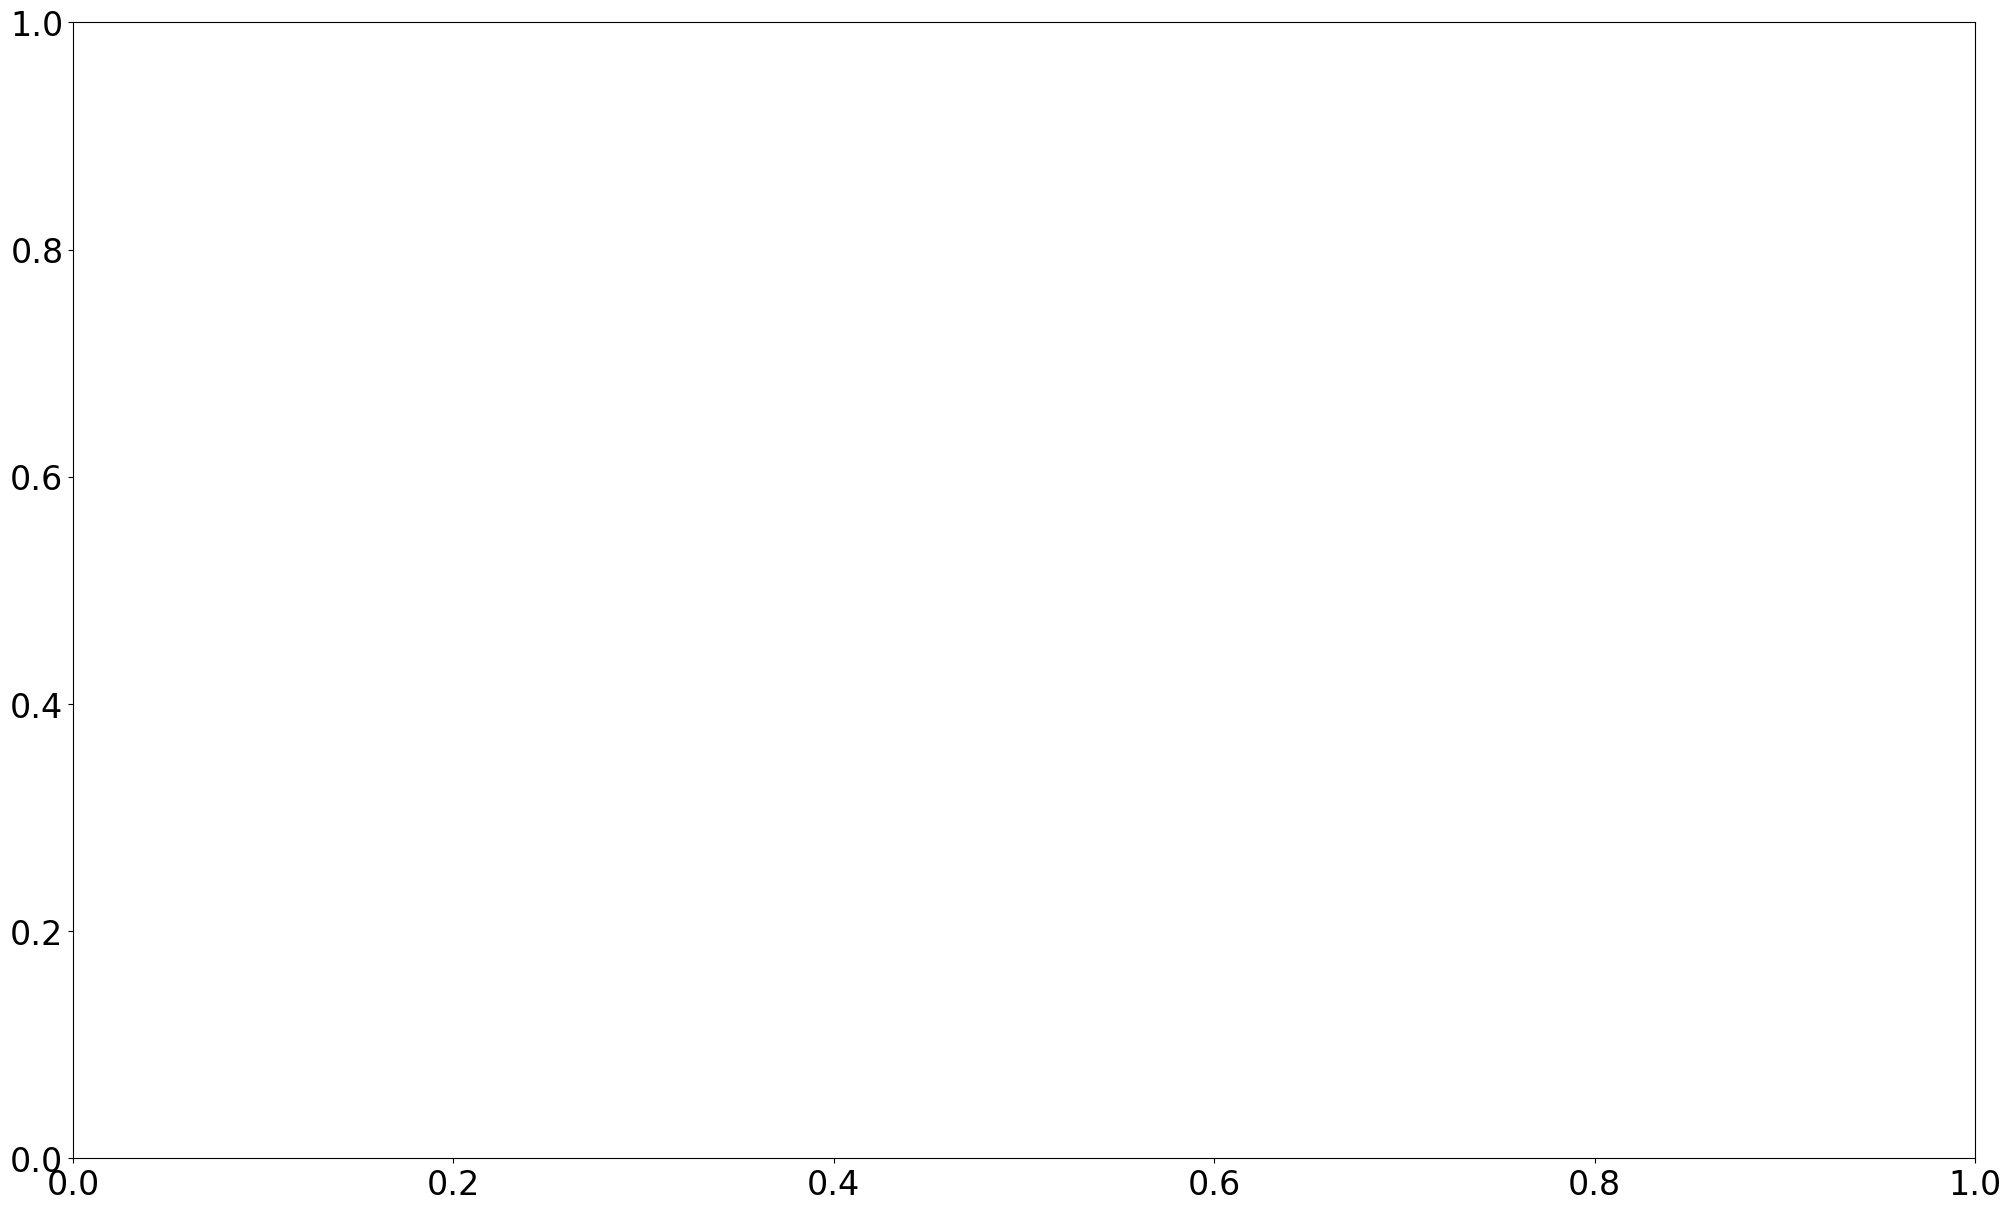

In [98]:
i, ci, di = 1, 0,  0

plot_statespace(statespace[i][ci][di], title=None, legend=True, coords=coords_names)

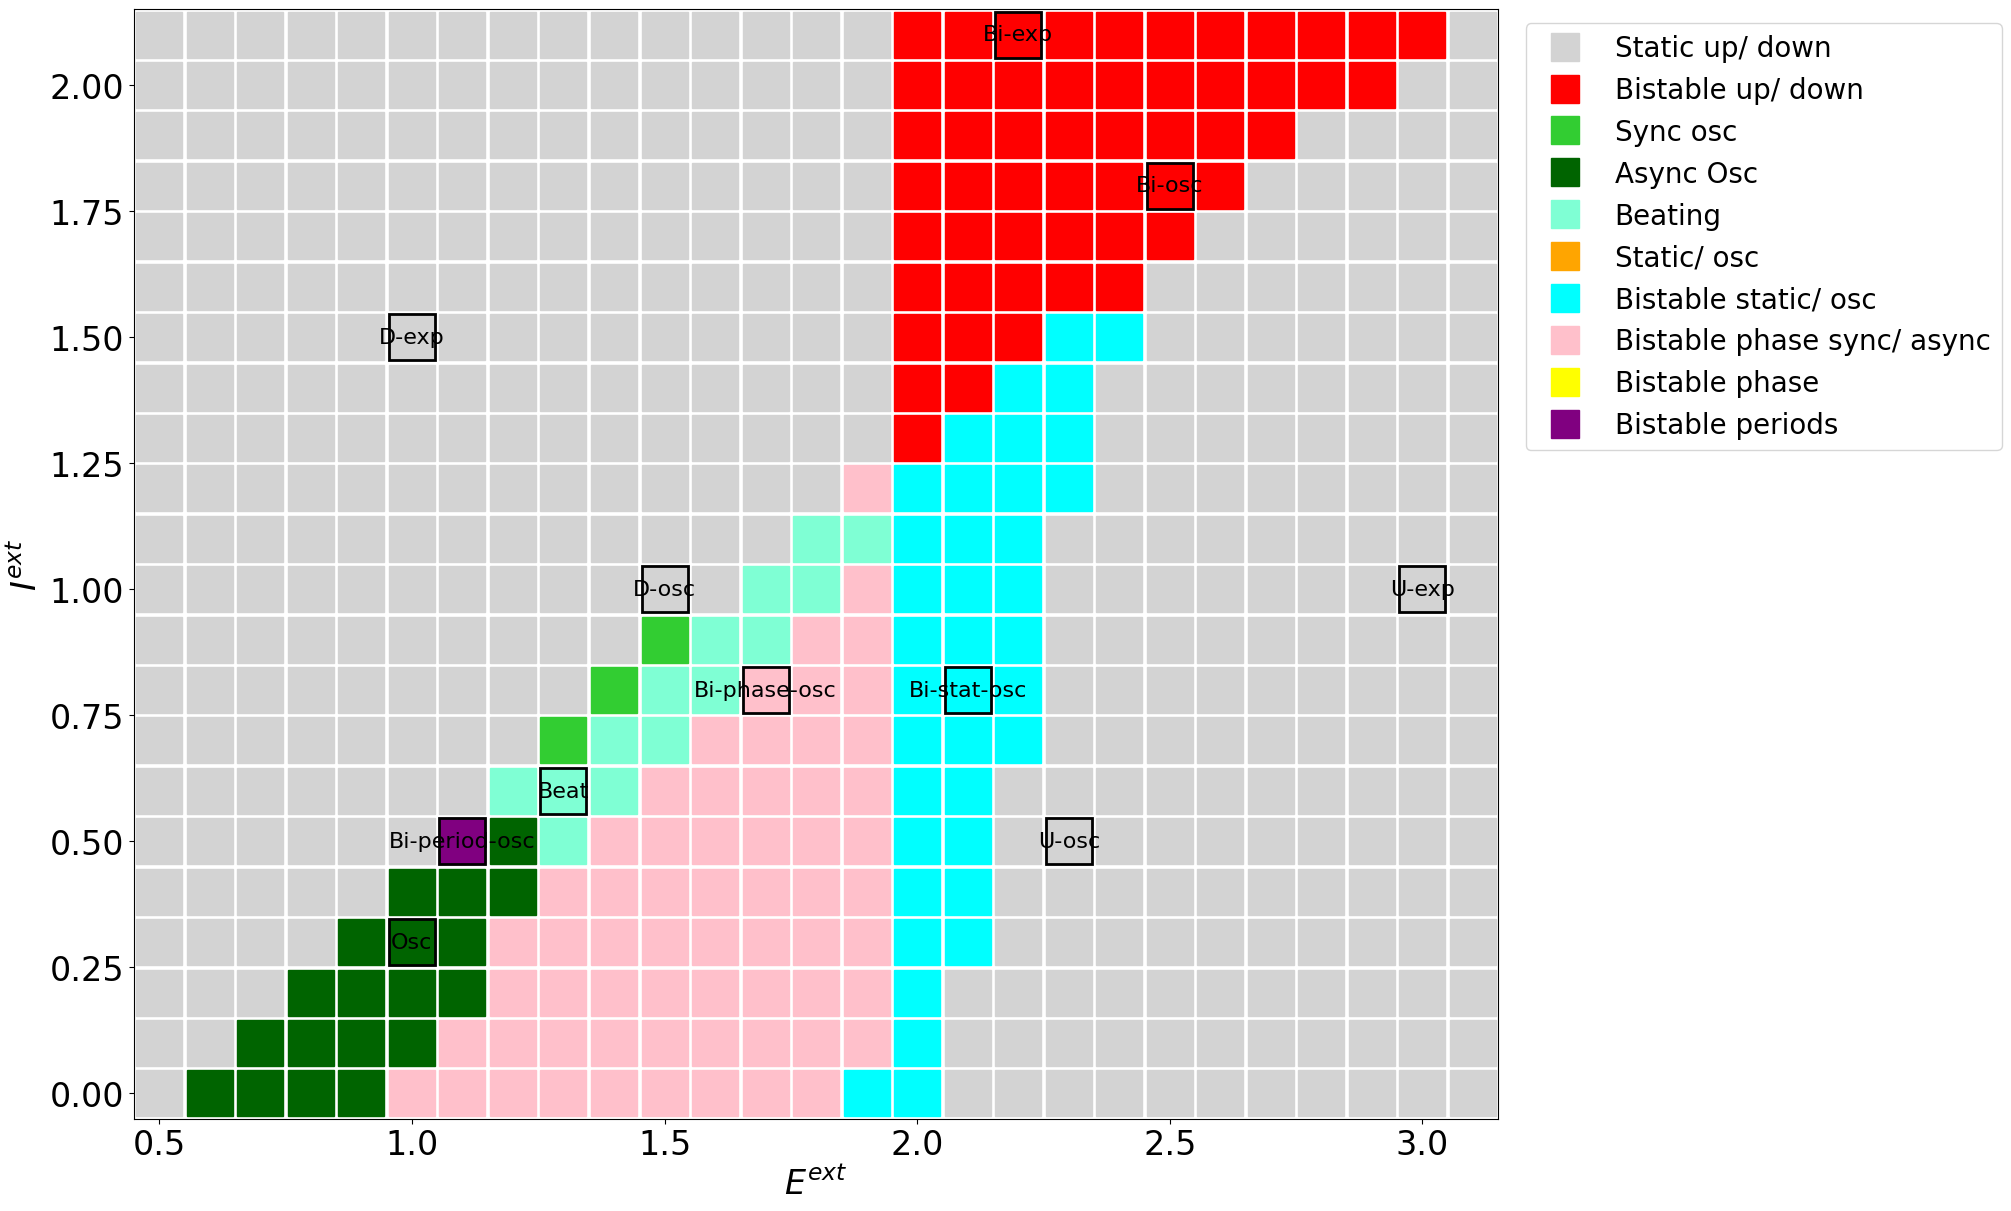

In [56]:
i, ci, di = 1, 5, 2

filename = "statespace_1_5_2_points.png"
plot_statespace(statespace[i][ci][di], title=None, filename=os.path.join(dir, filename), legend=True, coords=coords_names)

 delay =  0 , coupling =  6


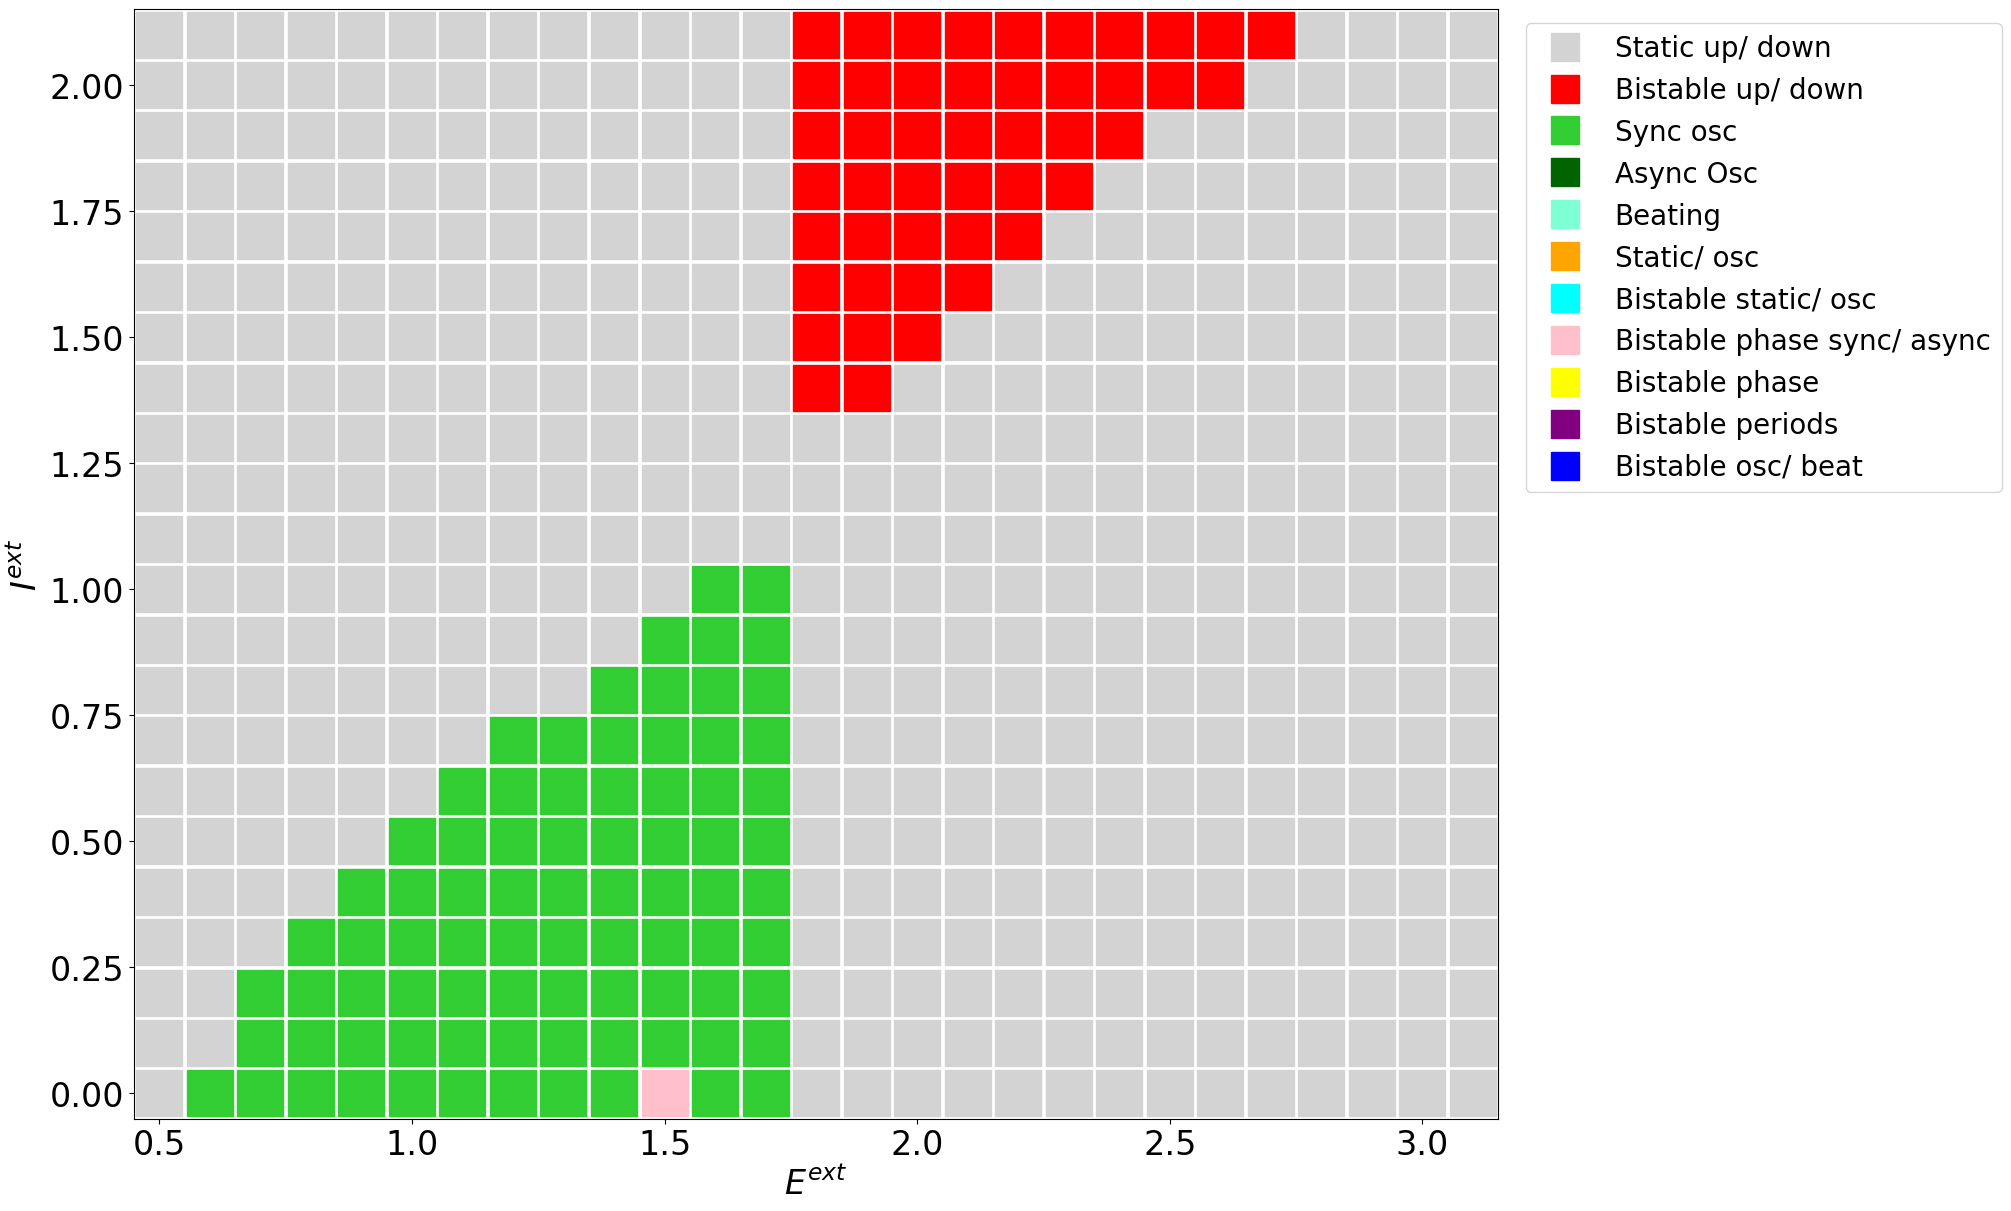

 delay =  1 , coupling =  6


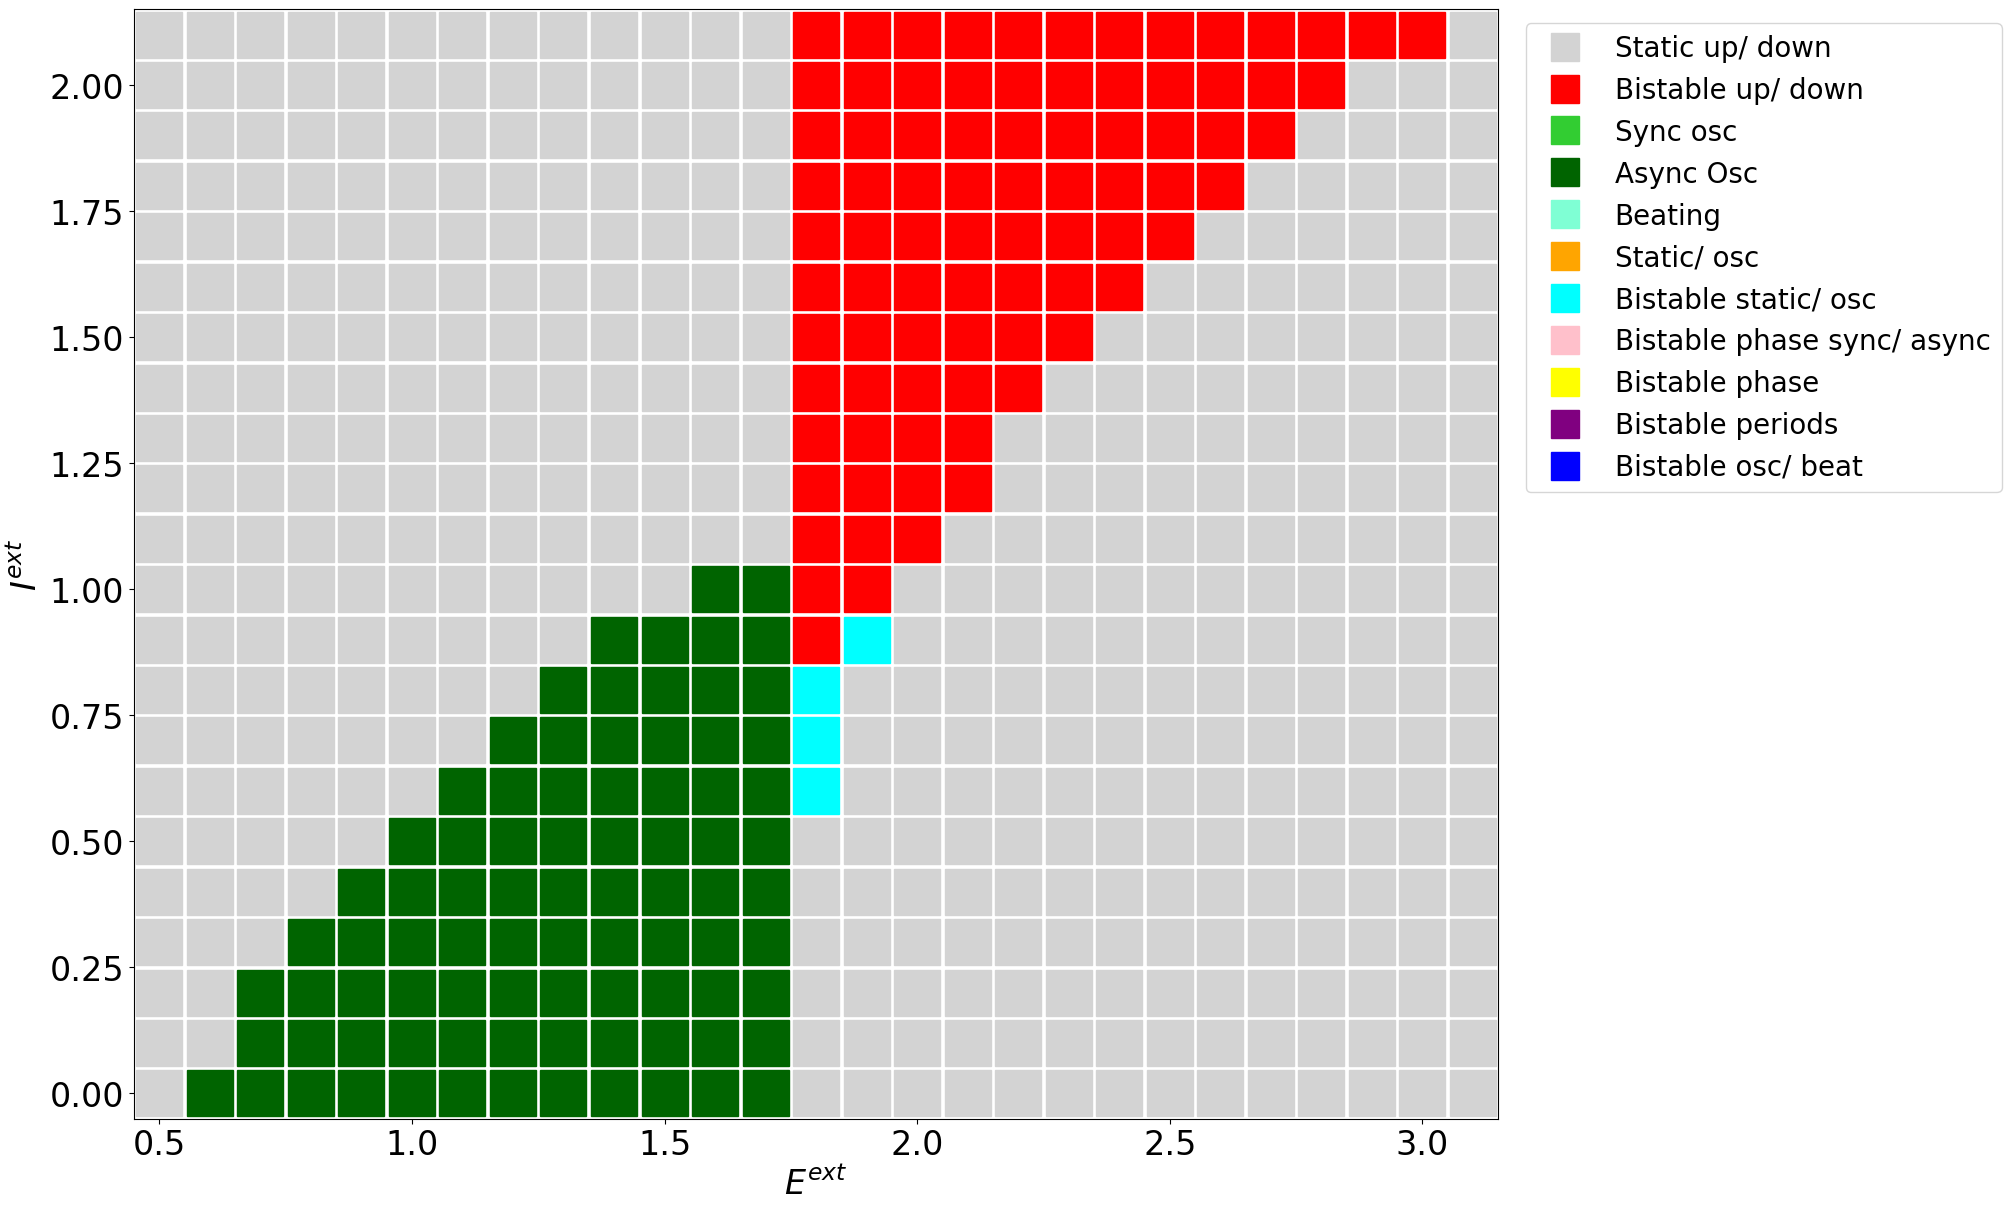

 delay =  2 , coupling =  6


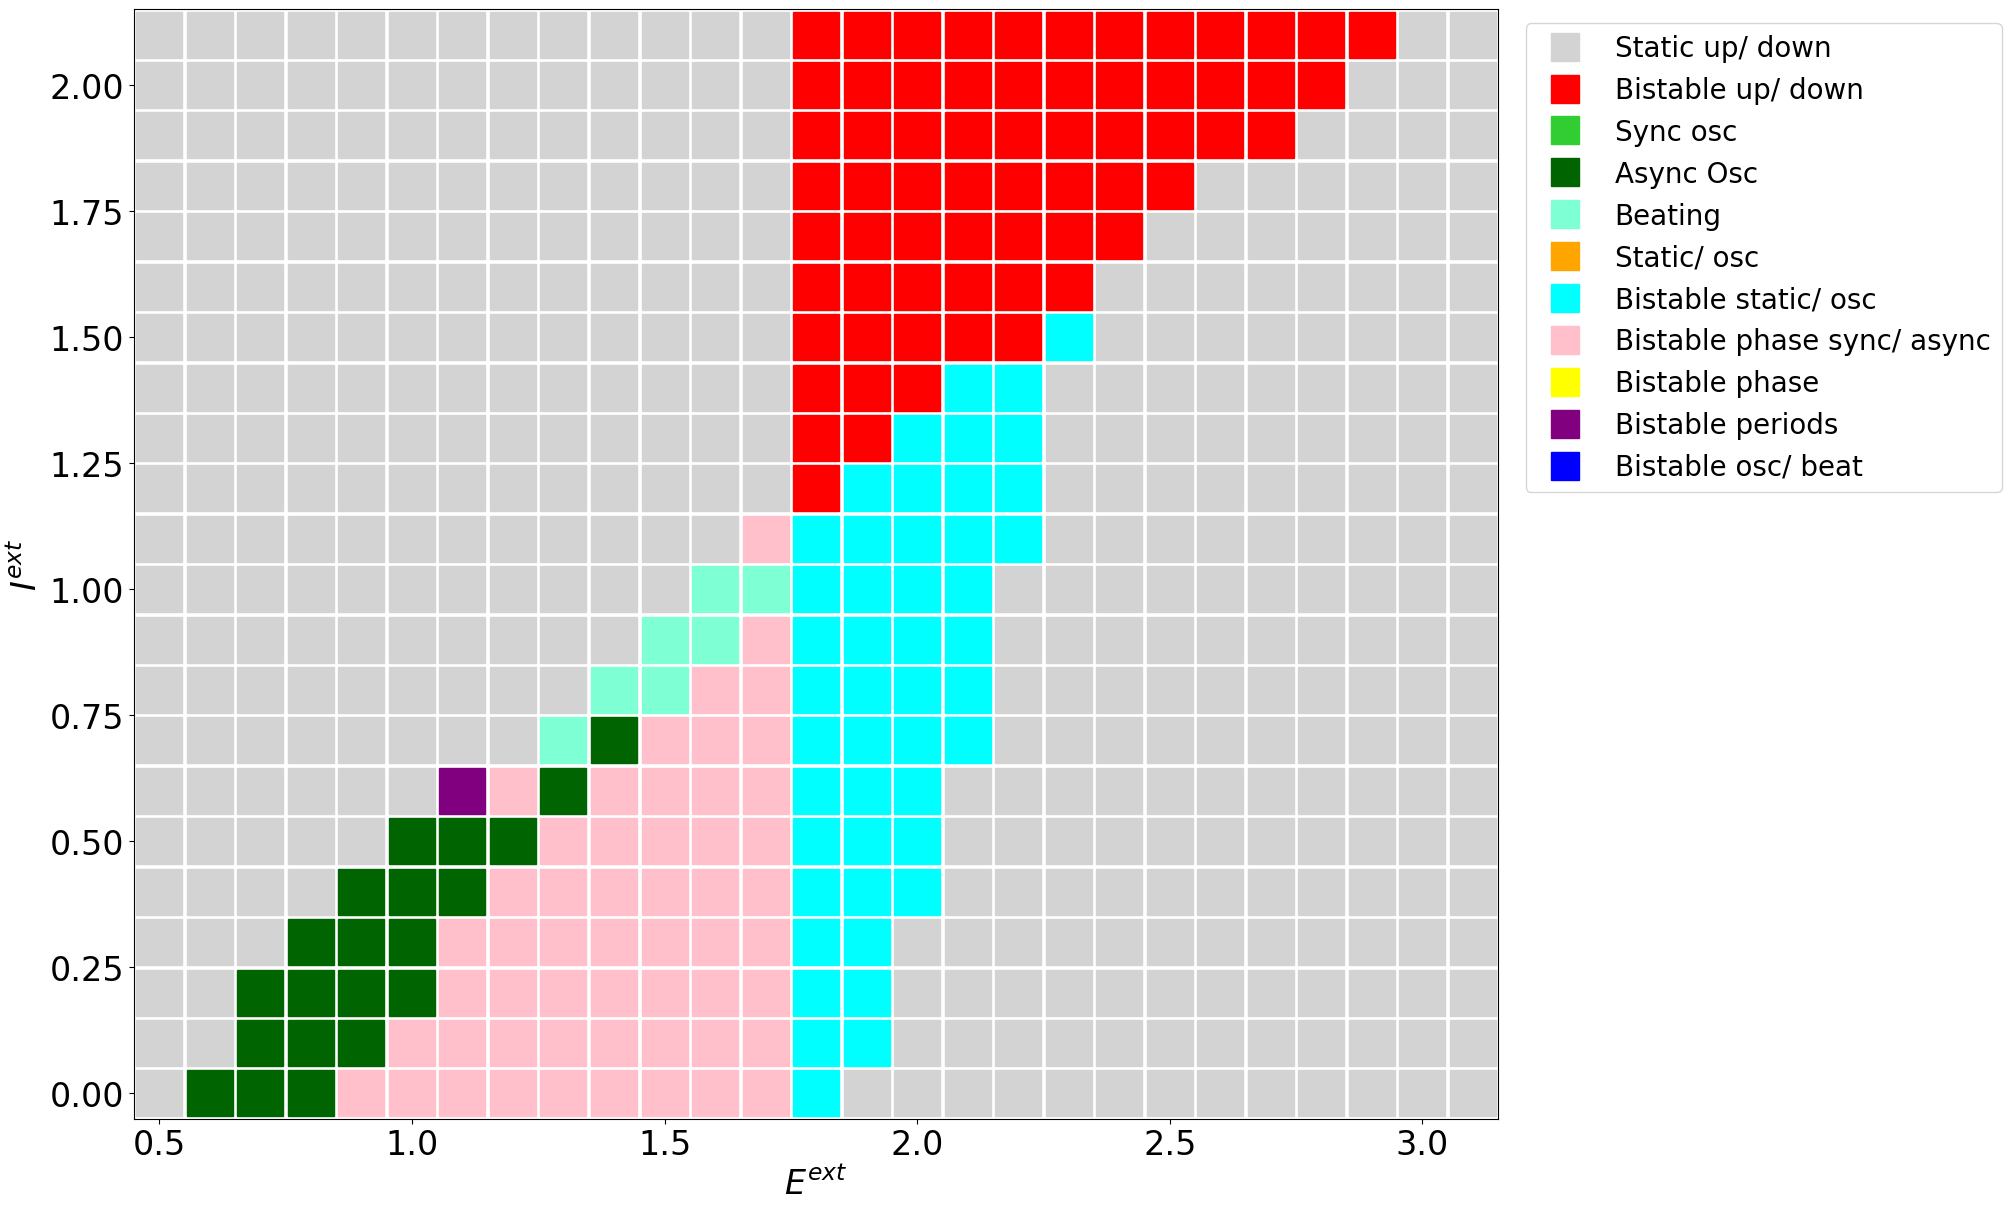

 delay =  3 , coupling =  6


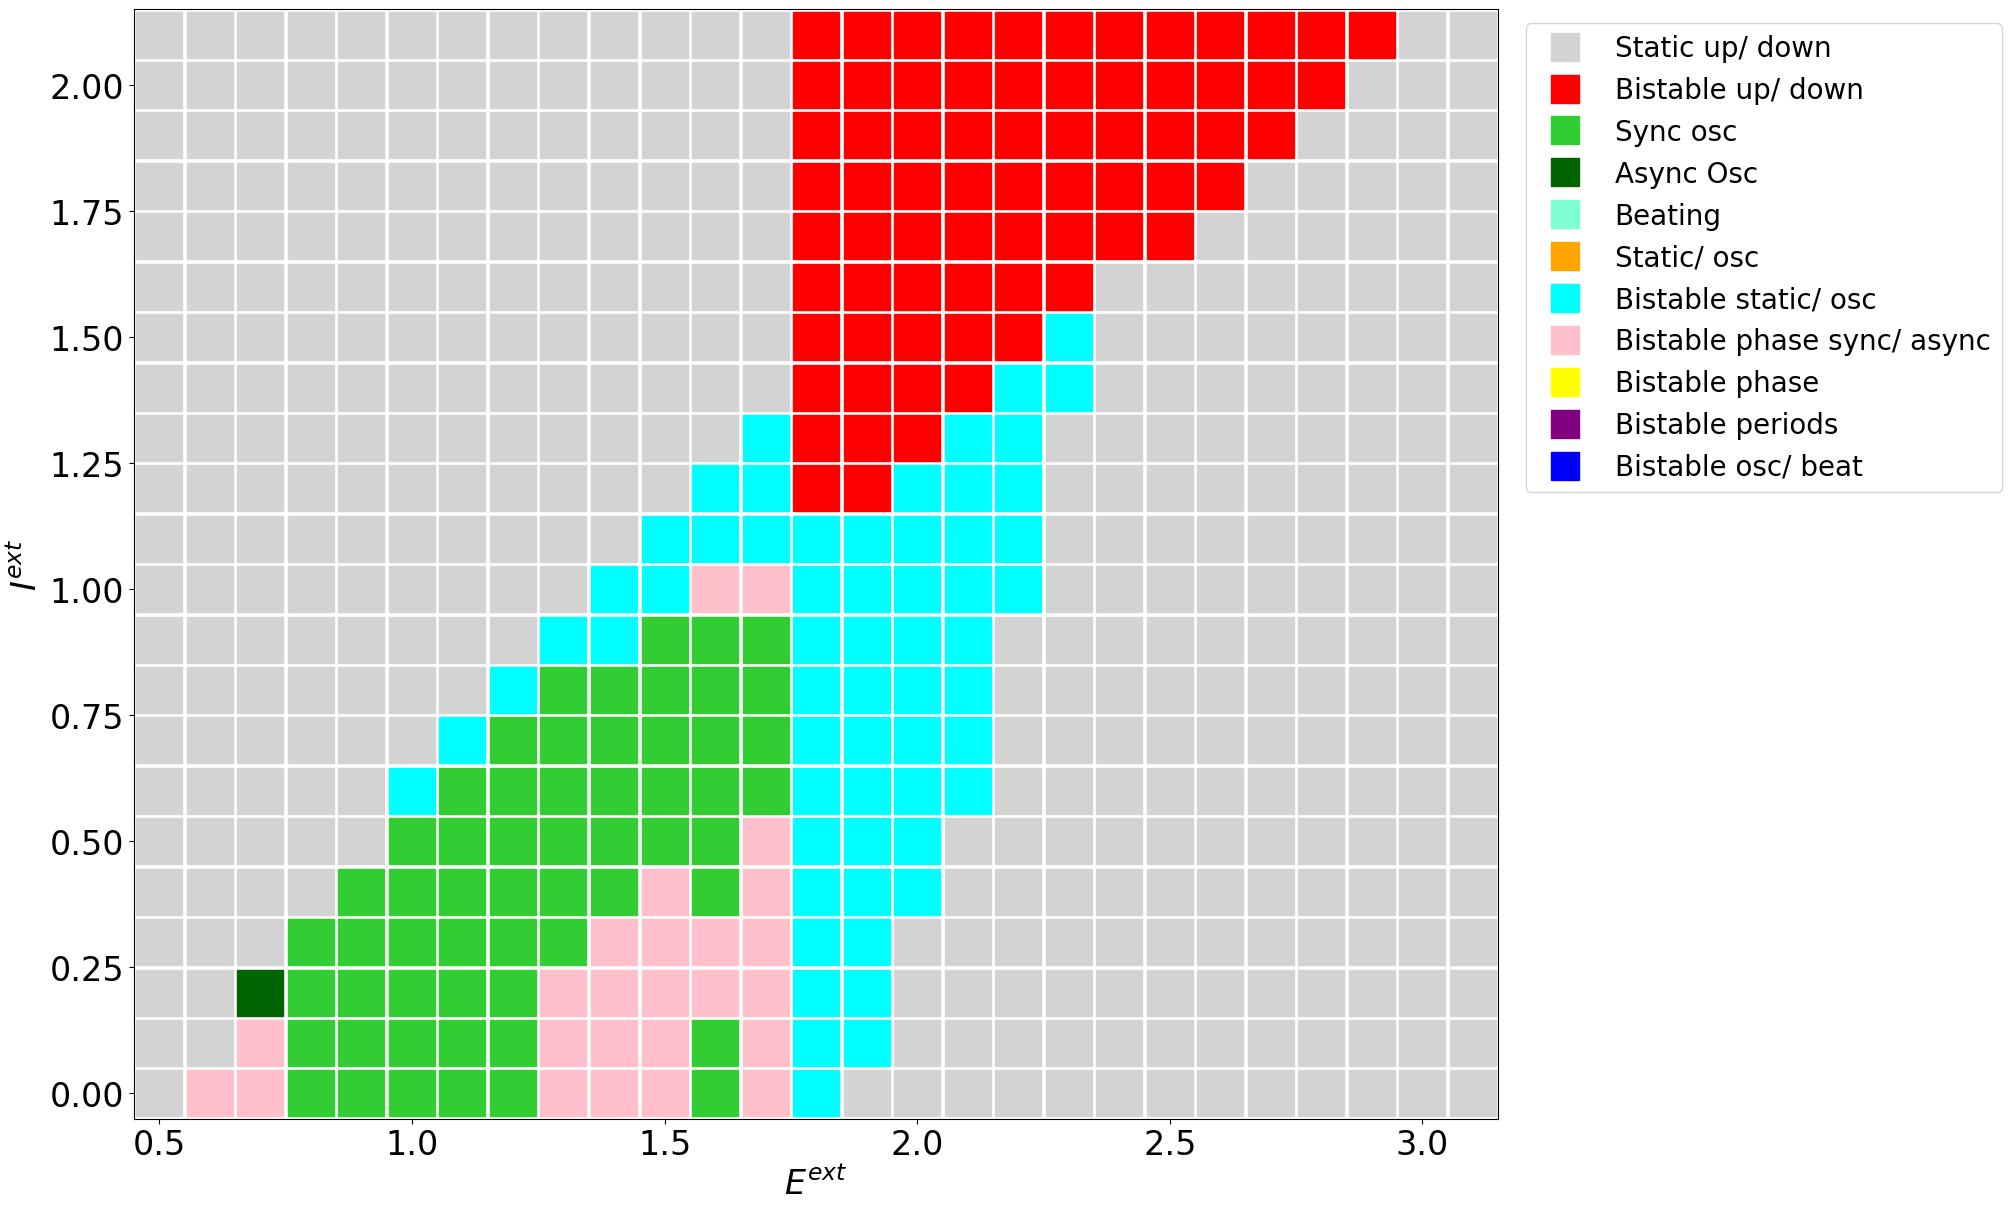

 delay =  4 , coupling =  6


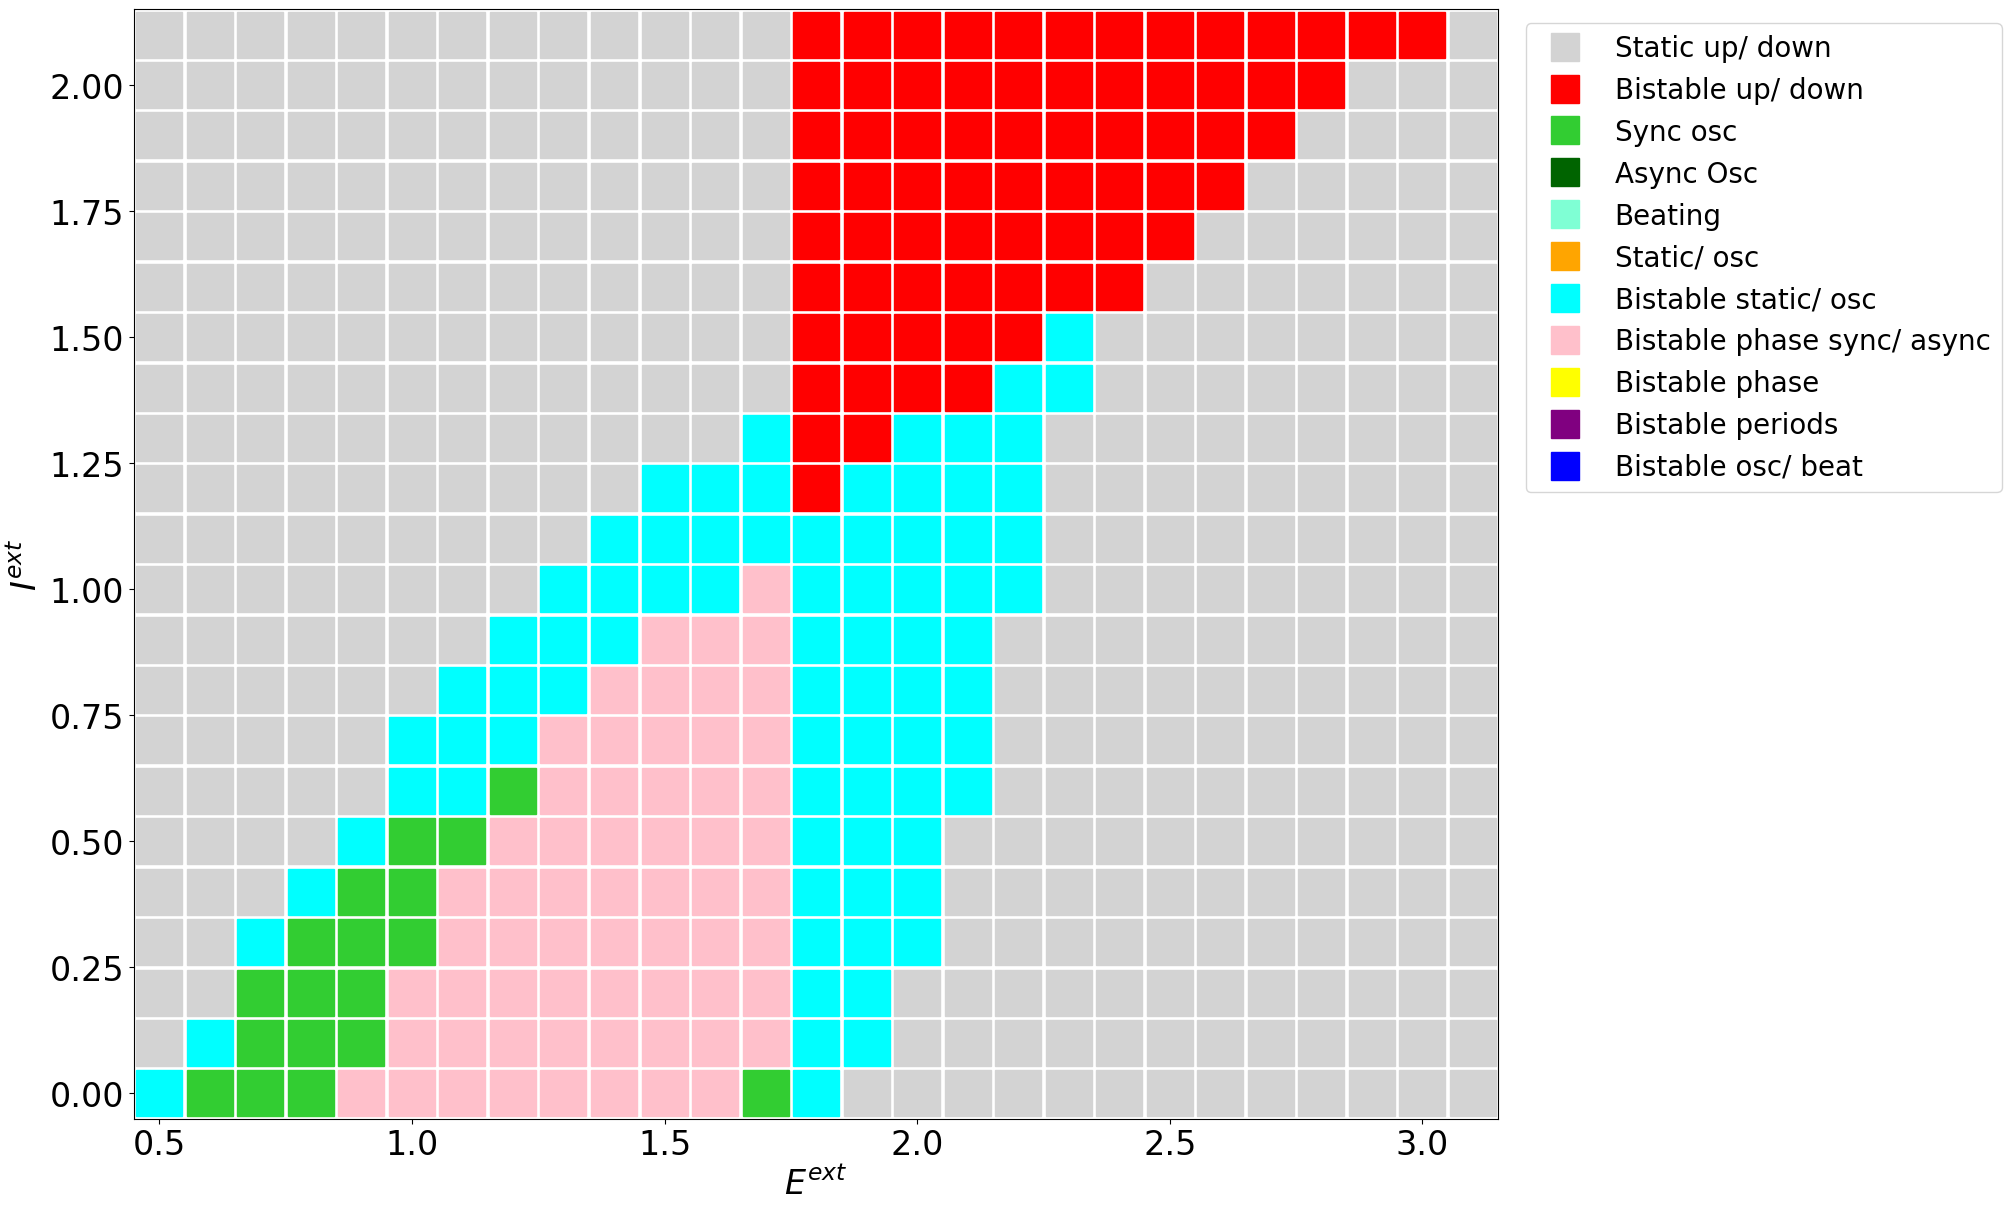

In [131]:
for i in range(len(cmats)):
    if i not in [1]: continue
    for ci in range(len(coupling_array)):
        for di in range(len(delay_array)):

            if ci == 0 and di != 0:
                continue

            if ci not in [6]: continue

            #title = "cmat = " + str(i) + ", coupling = " + str(coupling_array[ci]) + ", delay = " + str(delay_array[di])
            filename = "statespace_" + str(i) + "_" + str(ci) + "_" + str(di) + ".png"
            print(" delay = ", di, ", coupling = ", ci)
            plot_statespace(statespace[i][ci][di], title=None, filename=os.path.join(dir, filename), legend=True)

172 762
35 566


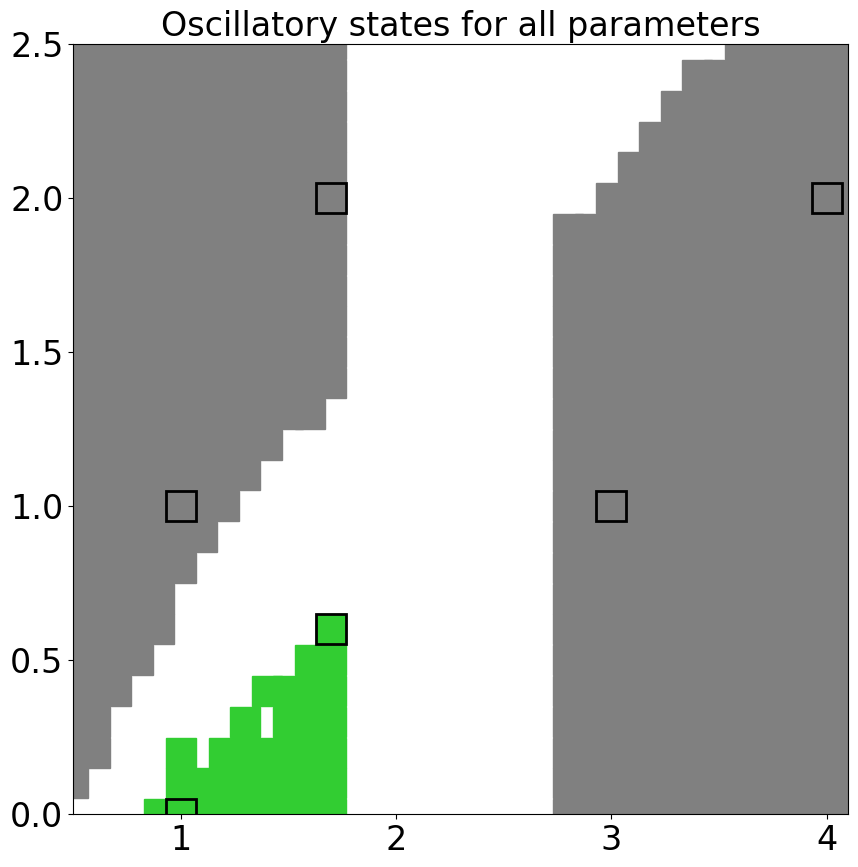

In [110]:
oscstates_000 = []
for si in range(len(statespace[0][0][0]["state"])):
    if statespace[0][0][0]["state"][si][0] == "osc":
        oscstates_000.append(statespace[0][0][0]["coords"][si])

statstates_000 = []
for si in range(len(statespace[0][0][0]["state"])):
    if statespace[0][0][0]["state"][si][0] == "static":
        statstates_000.append(statespace[0][0][0]["coords"][si])

print(len(oscstates_000), len(statstates_000))


for i in range(len(cmats)):
    for ci in range(len(coupling_array)):
        for di in range(len(delay_array)):

            if [i, ci, di] == [0,0,0]:
                continue

            if ci == 0 and di != 0:
                continue

            #print(i, ci, di)

            delind = []

            for coi in range(len(oscstates_000)):
                coords = oscstates_000[coi]
                oscstate = False

                for si in range(len(statespace[i][ci][di]["state"])):
                    if statespace[i][ci][di]["coords"][si] == coords:
                        if statespace[i][ci][di]["state"][si][0] == "osc":
                            oscstate = True

                if not oscstate:
                    delind.append(coi)

            for coi in reversed(delind):
                oscstates_000.pop(coi)

            
            delind = []

            for coi in range(len(statstates_000)):
                coords = statstates_000[coi]
                statstate = False

                for si in range(len(statespace[i][ci][di]["state"])):
                    if statespace[i][ci][di]["coords"][si] == coords:
                        if statespace[i][ci][di]["state"][si][0] == "static":
                            statstate = True

                if not statstate:
                    delind.append(coi)

            for coi in reversed(delind):
                statstates_000.pop(coi)

print(len(oscstates_000), len(statstates_000))

fig, ax = plt.subplots(figsize=(10,10))

for cs in statstates_000:
    ax.plot(cs[0], cs[1], marker="s", markersize=ms, color=cols[0])
for co in oscstates_000:
    ax.plot(co[0], co[1], marker="s", markersize=ms, color=cols[1])
for poi in coords_all:
    ax.plot(poi[0], poi[1], marker="s", markersize=ms, color=mpl.colors.to_rgba('b', 0.0), markeredgewidth=2, markeredgecolor="black")

ax.set_xlim(emin, emax)
ax.set_ylim(imin, imax)
ax.set_title("Oscillatory states for all parameters")

plt.savefig(os.path.join(dir, "osc_states.png"))
plt.show()

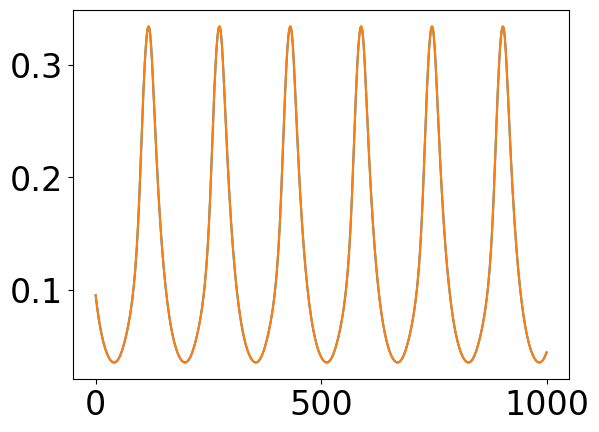

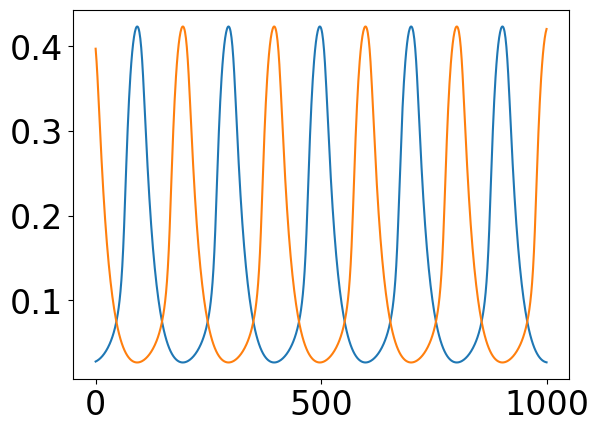

In [132]:
i, ci, di = 1, 3, 2
e_, i_ = 1., 0.

dmat = delay_array[di] * cmats[i] * 20.
                
model = WCModel(Cmat=cmats[i], Dmat=dmat)
model.params.K_gl = coupling_array[ci]
dt = 0.1
model.params.dt = dt

dur = 4.
i00, i01 = int(0.5 * dur * 1000/dt - 1000/dt), int(0.5 * dur * 1000/dt) - 1
i10, i11 = int(-1000/dt), -1

model.params['duration'] = dur * 1000 # Simulation time, ms
test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
test_input = np.vstack( ([test_input]*N))
stim_period = 19.
test_input[0,:int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)
test_input[1,:int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)

test_input[0,i01+1:i01+1+int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)
test_input[1,i01+1:i01+1+int(stim_period/dt)] = -5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)

model.params.exc_ext = e_ + test_input
model.params.inh_ext = i_

model.run()

plt.plot(model.exc[0,i01-1000:i01])
plt.plot(model.exc[1,i01-1000:i01])
plt.show()

plt.plot(model.exc[0,i11-1000:i11])
plt.plot(model.exc[1,i11-1000:i11])
plt.show()